In [1]:
from tensorflow.keras.layers import Input, GRU, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
import tensorflow.keras as keras

In [2]:
def define_nmt(hidden_size, batch_size, en_timesteps, en_vsize, fr_timesteps, fr_vsize):
    """ Defining a NMT model """

    # Define an input sequence and process it.
    if batch_size:
        encoder_inputs = Input(batch_shape=(batch_size, en_timesteps, en_vsize), name='encoder_inputs')
        decoder_inputs = Input(batch_shape=(batch_size, fr_timesteps - 1, fr_vsize), name='decoder_inputs')
    else:
        encoder_inputs = Input(shape=(en_timesteps, en_vsize), name='encoder_inputs')
        if fr_timesteps:
            decoder_inputs = Input(shape=(fr_timesteps - 1, fr_vsize), name='decoder_inputs')
        else:
            decoder_inputs = Input(shape=(None, fr_vsize), name='decoder_inputs')

    # Encoder GRU
    encoder_gru = GRU(hidden_size, return_sequences=True, return_state=True, name='encoder_gru')
    encoder_out, encoder_state = encoder_gru(encoder_inputs)

    # Set up the decoder GRU, using `encoder_states` as initial state.
    decoder_gru = GRU(hidden_size, return_sequences=True, return_state=True, name='decoder_gru')
    decoder_out, decoder_state = decoder_gru(decoder_inputs, initial_state=encoder_state)

    # Attention layer
    #attn_layer = AttentionLayer(name='attention_layer')
    #attn_out, attn_states = attn_layer([encoder_out, decoder_out])

    # Concat attention input and decoder GRU output
    #decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_out, attn_out])

    # Dense layer
    dense = Dense(fr_vsize, activation='softmax', name='softmax_layer')
    dense_time = TimeDistributed(dense, name='time_distributed_layer')
    decoder_pred = dense_time(decoder_out)

    # Full model
    full_model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_pred)
    full_model.compile(optimizer='adam', loss='categorical_crossentropy')

    full_model.summary()

    """ Inference model """
    batch_size = 1

    """ Encoder (Inference) model """
    encoder_inf_inputs = Input(batch_shape=(batch_size, en_timesteps, en_vsize), name='encoder_inf_inputs')
    encoder_inf_out, encoder_inf_state = encoder_gru(encoder_inf_inputs)
    encoder_model = Model(inputs=encoder_inf_inputs, outputs=[encoder_inf_out, encoder_inf_state])

    """ Decoder (Inference) model """
    decoder_inf_inputs = Input(batch_shape=(batch_size, 1, fr_vsize), name='decoder_word_inputs')
    #encoder_inf_states = Input(batch_shape=(batch_size, en_timesteps, hidden_size), name='encoder_inf_states')
    decoder_init_state = Input(batch_shape=(batch_size, hidden_size), name='decoder_init')

    decoder_inf_out, decoder_inf_state = decoder_gru(decoder_inf_inputs, initial_state=decoder_init_state)
    #attn_inf_out, attn_inf_states = attn_layer([encoder_inf_states, decoder_inf_out])
    #decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_inf_out, attn_inf_out])
    decoder_inf_pred = TimeDistributed(dense)(decoder_inf_out)
    decoder_model = Model(inputs=[decoder_inf_inputs, decoder_init_state],
                          outputs=[decoder_inf_pred, decoder_inf_state])

    return full_model, encoder_model, decoder_model

In [3]:
nmt = define_nmt(64, None, 20, 30, 20, 20)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(None, 20, 30)]     0                                            
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     [(None, 19, 20)]     0                                            
__________________________________________________________________________________________________
encoder_gru (GRU)               [(None, 20, 64), (No 18432       encoder_inputs[0][0]             
__________________________________________________________________________________________________
decoder_gru (GRU)               [(None, 19, 64), (No 16512       decoder_inputs[0][0]             
                                                                 encoder_gru[0][1]            

In [4]:
from tensorflow.keras.utils import to_categorical
import numpy as np
import os, sys

In [5]:
from data_helper import read_data, sents2sequences, get_data

In [6]:
from matplotlib.pyplot import plot

In [7]:
def read_data(filename):
    """ Reading the zip file to extract text """
    text = []
    with open(filename, 'r', encoding='utf-8') as f:
        i = 0
        for row in f:
            text.append(row)
            i += 1
    return text

In [8]:
def get_data(train_size, random_seed=100):

    """ Getting randomly shuffled training / testing data """
    DATA_DIR = '/home/sadisari/Projects/attention_keras/data'
    en_text = read_data(os.path.join(DATA_DIR, 'small_vocab_en.txt'))
    fr_text = read_data(os.path.join(DATA_DIR, 'small_vocab_fr.txt'))

    fr_text = ['sos ' + sent[:-1] + 'eos .'  if sent.endswith('.') else 'sos ' + sent + ' eos .' for sent in fr_text]

    np.random.seed(random_seed)
    inds = np.arange(len(en_text))
    np.random.shuffle(inds)

    train_inds = inds[:train_size]
    test_inds = inds[train_size:]
    tr_en_text = [en_text[ti] for ti in train_inds]
    tr_fr_text = [fr_text[ti] for ti in train_inds]

    ts_en_text = [en_text[ti] for ti in test_inds]
    ts_fr_text = [fr_text[ti] for ti in test_inds]

    return tr_en_text, tr_fr_text, ts_en_text, ts_fr_text

In [9]:
batch_size = 64
hidden_size = 96
en_timesteps, fr_timesteps = 20, 20

In [10]:
def preprocess_data(en_tokenizer, fr_tokenizer, en_text, fr_text, en_timesteps, fr_timesteps):
    """ Preprocessing data and getting a sequence of word indices """

    en_seq = sents2sequences(en_tokenizer, en_text, reverse=False, padding_type='pre', pad_length=en_timesteps)
    fr_seq = sents2sequences(fr_tokenizer, fr_text, pad_length=fr_timesteps)
    return en_seq, fr_seq

In [11]:
debug = True
""" Hyperparameters """

train_size = 100000 if not debug else 10000
filename = ''

tr_en_text, tr_fr_text, ts_en_text, ts_fr_text = get_data(train_size=train_size)

In [12]:
""" Defining tokenizers """
en_tokenizer = keras.preprocessing.text.Tokenizer(oov_token='UNK')
en_tokenizer.fit_on_texts(tr_en_text)

fr_tokenizer = keras.preprocessing.text.Tokenizer(oov_token='UNK')
fr_tokenizer.fit_on_texts(tr_fr_text)

In [13]:
""" Getting preprocessed data """
en_seq, fr_seq = preprocess_data(en_tokenizer, fr_tokenizer, tr_en_text, tr_fr_text, en_timesteps, fr_timesteps)
en_seq_tst, fr_seq_tst = preprocess_data(en_tokenizer, fr_tokenizer, ts_en_text, ts_fr_text, en_timesteps, fr_timesteps)

en_vsize = max(en_tokenizer.index_word.keys()) + 1
fr_vsize = max(fr_tokenizer.index_word.keys()) + 1

In [14]:
""" Defining the full model """
full_model, infer_enc_model, infer_dec_model = define_nmt(
    hidden_size=hidden_size, batch_size=batch_size,
    en_timesteps=en_timesteps, fr_timesteps=fr_timesteps,
    en_vsize=en_vsize, fr_vsize=fr_vsize)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(64, 20, 199)]      0                                            
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     [(64, 19, 315)]      0                                            
__________________________________________________________________________________________________
encoder_gru (GRU)               [(64, 20, 96), (64,  85536       encoder_inputs[0][0]             
__________________________________________________________________________________________________
decoder_gru (GRU)               [(64, 19, 96), (64,  118944      decoder_inputs[0][0]             
                                                                 encoder_gru[0][1]          

In [15]:
tst_en_onehot_seq = to_categorical(en_seq_tst[:batch_size, :], num_classes=en_vsize)
tst_fr_onehot_seq = to_categorical(fr_seq_tst[:batch_size, :], num_classes=fr_vsize)

In [17]:
n_epochs = 100

In [18]:
losses = []
losses_val = []
for ep in range(n_epochs):
    for bi in range(0, en_seq.shape[0] - batch_size, batch_size):
        en_onehot_seq = to_categorical(en_seq[bi:bi + batch_size, :], num_classes=en_vsize)
        fr_onehot_seq = to_categorical(fr_seq[bi:bi + batch_size, :], num_classes=fr_vsize)
        full_model.train_on_batch([en_onehot_seq, fr_onehot_seq[:, :-1, :]], fr_onehot_seq[:, 1:, :])
        l = full_model.evaluate([en_onehot_seq, fr_onehot_seq[:, :-1, :]], fr_onehot_seq[:, 1:, :],
                                batch_size=batch_size, verbose=0)
        lv = full_model.evaluate([tst_en_onehot_seq, tst_fr_onehot_seq[:, :-1, :]], tst_fr_onehot_seq[:, 1:, :]
                                , verbose=0)
        losses.append(l)
        losses_val.append(lv)

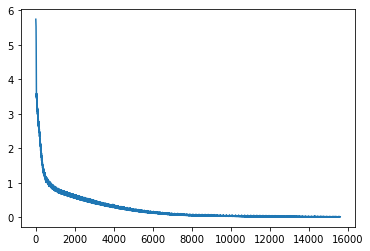

In [21]:
plot(losses)

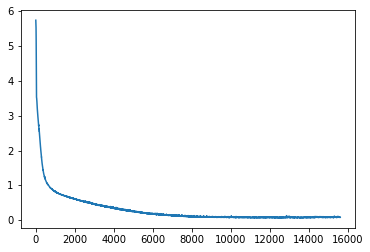

In [22]:
plot(losses_val)

In [23]:
""" Index2word """
en_index2word = dict(zip(en_tokenizer.word_index.values(), en_tokenizer.word_index.keys()))
fr_index2word = dict(zip(fr_tokenizer.word_index.values(), fr_tokenizer.word_index.keys()))

In [24]:
def infer_nmt(encoder_model, decoder_model, test_en_seq, en_vsize, fr_vsize):
    """
    Infer logic
    :param encoder_model: keras.Model
    :param decoder_model: keras.Model
    :param test_en_seq: sequence of word ids
    :param en_vsize: int
    :param fr_vsize: int
    :return:
    """
    test_fr_seq = sents2sequences(fr_tokenizer, ['sos'], fr_vsize)
    test_en_onehot_seq = to_categorical(test_en_seq, num_classes=en_vsize)
    test_fr_onehot_seq = np.expand_dims(to_categorical(test_fr_seq, num_classes=fr_vsize), 1)

    enc_outs, enc_last_state = encoder_model.predict(test_en_onehot_seq)
    dec_state = enc_last_state
    #attention_weights = []
    #dec_in = test_fr_onehot_seq
    fr_text = ''
    for i in range(20):
        dec_out, dec_state = decoder_model.predict([test_fr_onehot_seq, dec_state])
        dec_ind = np.argmax(dec_out, axis=-1)[0, 0]

        if dec_ind == 0:
            break
        test_fr_seq = sents2sequences(fr_tokenizer, [fr_index2word[dec_ind]], fr_vsize)
        test_fr_onehot_seq = np.expand_dims(to_categorical(test_fr_seq, num_classes=fr_vsize), 1)

        #attention_weights.append((dec_ind, attention))
        fr_text += fr_index2word[dec_ind] + ' '

    return fr_text

In [32]:
""" Inferring with trained model """
test_en = ts_en_text[1]
print('Translating: {}'.format(test_en))

test_en_seq = sents2sequences(en_tokenizer, [test_en], pad_length=en_timesteps)
test_fr = infer_nmt(
    encoder_model=infer_enc_model, decoder_model=infer_dec_model,
    test_en_seq=test_en_seq, en_vsize=en_vsize, fr_vsize=fr_vsize)
print('\tFrench: {}'.format(test_fr))

Translating: we like lemons , oranges , and grapes .

	French: paris est généralement agréable en novembre et il est généralement humide en janvier eos 


In [43]:
test_en_seq = sents2sequences(en_tokenizer, [ts_en_text[0]], pad_length=en_timesteps)
test_en_onehot_seq = to_categorical(test_en_seq, num_classes=en_vsize)

In [44]:
test_en_onehot_seq.shape

(1, 20, 199)

In [45]:
enc_outs, enc_last_state = infer_enc_model.predict(test_en_onehot_seq)

In [49]:
enc_outs.shape

(1, 20, 96)

In [48]:
enc_last_state.shape

(1, 96)